In [ ]:
run_get_data = True # Upload the kaggle.json and make True if this hasn't been done once.
epochs_num = 20
k_folds = 10

if run_get_data:
  !pip install -q kaggle
  !pip install -q keras-tuner
  !pip install nltk

  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle competitions download -c nlp-getting-started

  !unzip -q nlp-getting-started.zip -d /content/data
  !echo "Unzip complete"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00
  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 115MB/s]
Unzip complete


In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import nltk
from nltk import pos_tag, FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report

import tensorflow as tf

import keras_tuner as kt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, GlobalAveragePooling1D, Conv1D, GlobalMaxPooling1D

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
class DisasterTweetAnalysis:
    def __init__(self, train_path='/content/data/train.csv', test_path='/content/data/test.csv'):
        self.train_path = train_path
        self.test_path = test_path
        self.train_df = None
        self.test_df = None
        self.tokenizer = None
        self.tfidf_vectorizer = None
        self.X_train = None
        self.X_val = None
        self.y_train = None
        self.y_val = None
        self.max_sequence_length = None
        self.best_model = ''

    # def download_data(self, run_get_data=True):
    #     """Download and unzip the Kaggle dataset (only needed once)."""
    #     if run_get_data:
    #         subprocess.call("pip install -q kaggle", shell=True)
    #         subprocess.call("pip install -q keras-tuner", shell=True)
    #         subprocess.call("pip install -q nltk", shell=True)
    #         os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    #         subprocess.call("cp kaggle.json ~/.kaggle/", shell=True)
    #         subprocess.call("chmod 600 ~/.kaggle/kaggle.json", shell=True)
    #         subprocess.call("kaggle competitions download -c nlp-getting-started", shell=True)
    #         subprocess.call("unzip -q nlp-getting-started.zip -d /content/data", shell=True)
    #         print("Data download and unzip complete.")

    def load_data(self):
        self.train_df = pd.read_csv(self.train_path)
        self.test_df = pd.read_csv(self.test_path)

        # Drop the 'id' column from training data only. I left in validation because it needs to cross referene for the submission
        if 'id' in self.train_df.columns:
            self.train_df.drop(columns=['id'], inplace=True)

        print("Train shape:", self.train_df.shape)
        print("Test shape:", self.test_df.shape)
        return self.train_df, self.test_df

    def initial_eda(self):
        if self.train_df is None:
            return
        print("First few rows of training data:")
        display(self.train_df.head())

        print("\nMissing values in train set:")
        print(self.train_df.isnull().sum())

        # Plot target distribution
        plt.figure(figsize=(6,4))
        sns.countplot(x='target', data=self.train_df)
        plt.title('Distribution of Disaster Tweets')
        plt.show()

        # Plot tweet length distribution
        self.train_df['text_length'] = self.train_df['text'].apply(lambda x: len(x.split()))
        plt.figure(figsize=(8,6))
        sns.histplot(self.train_df['text_length'], bins=30)
        plt.title('Tweet Length Distribution')
        plt.xlabel('Number of words')
        plt.show()

    def k_fold_split(self, k=5, random_state=1337):
        if 'clean_text' not in self.train_df.columns:
            return

        X = self.train_df['clean_text']
        y = self.train_df['target']

        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
        self.k_fold_splits = list(skf.split(X, y))

        print(f"{k}-fold cross-validation splits created.")
        return self.k_fold_splits

    def word_cloud(self):
        disaster_text = ' '.join(self.train_df[self.train_df['target'] == 1]['clean_text'].tolist())
        non_disaster_text = ' '.join(self.train_df[self.train_df['target'] == 0]['clean_text'].tolist())

        wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
        wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_text)

        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud_disaster, interpolation='bilinear')
        plt.axis('off')
        plt.title('Disaster Tweets Word Cloud')

        plt.subplot(1, 2, 2)
        plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
        plt.axis('off')
        plt.title('Non-Disaster Tweets Word Cloud')
        plt.show()

    def part_of_speech(self):
        sample_text = self.train_df['clean_text'].iloc[0]
        tokens = word_tokenize(sample_text)
        tagged_tokens = pos_tag(tokens)

        print("POS tagging for sample tweet:")
        print(tagged_tokens)

    def freq_dist(self):
        all_words = ' '.join(self.train_df['clean_text']).split()

        freq_dist = FreqDist(all_words)

        print("Most common words:")
        print(freq_dist.most_common(20))

        plt.figure(figsize=(10, 5))
        freq_dist.plot(20)
        plt.title("Top 20 Most Common Words in Tweets")
        plt.show()

    @staticmethod
    def clean_text(text):
        text = text.lower()
        # removes url
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        # removes hashtags, possibly could lead to lower acc though?
        text = re.sub(r'\@\w+|\#', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_tokens)

    def apply_cleaning(self):
        if self.train_df is None or self.test_df is None:
            return
        self.train_df['clean_text'] = self.train_df['text'].apply(self.clean_text)
        self.test_df['clean_text'] = self.test_df['text'].apply(self.clean_text)
        print("Text cleaning complete.")

        def clean_feature(text):
            text = str(text).lower().strip()
            text = re.sub(r'[^a-z0-9\s]', '', text)
            return text

        self.train_df['clean_keyword'] = self.train_df['keyword'].fillna('unknown').apply(clean_feature)
        self.train_df['clean_location'] = self.train_df['location'].fillna('unknown').apply(clean_feature)
        self.test_df['clean_keyword'] = self.test_df['keyword'].fillna('unknown').apply(clean_feature)
        self.test_df['clean_location'] = self.test_df['location'].fillna('unknown').apply(clean_feature)

        print("Text, keyword, and location cleaning complete.")

    def split_data(self, test_size=0.2, random_state=1337):
        if 'clean_text' not in self.train_df.columns:
            return
        X = self.train_df['clean_text']
        y = self.train_df['target']
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
        print("Hold-out split complete.")
        return self.X_train, self.X_val, self.y_train, self.y_val

    def plot_history(self, history):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_avg_history(self, histories):
        n = len(histories)
        if n == 0:
            return

        # Assume each history has the same number of epochs.
        epochs = len(histories[0]['accuracy'])
        avg_acc = []
        avg_val_acc = []
        avg_loss = []
        avg_val_loss = []

        for epoch in range(epochs):
            sum_acc = sum(history['accuracy'][epoch] for history in histories)
            sum_val_acc = sum(history['val_accuracy'][epoch] for history in histories)
            sum_loss = sum(history['loss'][epoch] for history in histories)
            sum_val_loss = sum(history['val_loss'][epoch] for history in histories)
            avg_acc.append(sum_acc / n)
            avg_val_acc.append(sum_val_acc / n)
            avg_loss.append(sum_loss / n)
            avg_val_loss.append(sum_val_loss / n)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(avg_acc, label='Avg Train Accuracy')
        plt.plot(avg_val_acc, label='Avg Validation Accuracy')
        plt.title('Average Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(avg_loss, label='Avg Train Loss')
        plt.plot(avg_val_loss, label='Avg Validation Loss')
        plt.title('Average Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def tune_lstm_model(self, max_num_words=10000, max_sequence_length=100, epochs=5, batch_size=32, tuner_epochs=5, k=5):
        if not hasattr(self, 'k_fold_splits'):
            self.k_fold_split(k=k)
        fold_results = []
        histories_list = []
        final_model = None
        for fold, (train_idx, val_idx) in enumerate(self.k_fold_splits):
            print(f"\nTraining Fold {fold+1}/{k} for LSTM...")
            X_train = self.train_df.iloc[train_idx]['clean_text']
            X_val = self.train_df.iloc[val_idx]['clean_text']
            y_train = self.train_df.iloc[train_idx]['target']
            y_val = self.train_df.iloc[val_idx]['target']

            tokenizer = Tokenizer(num_words=max_num_words, oov_token='<OOV>')
            tokenizer.fit_on_texts(X_train)
            X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_sequence_length)
            X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_sequence_length)

            def build_lstm_model_hp(hp):
                model = Sequential([
                    Embedding(max_num_words, hp.Choice('embedding_dim', values=[32, 64, 128]), input_length=max_sequence_length),
                    LSTM(hp.Int('lstm_units', 32, 128, step=32), return_sequences=True),
                    GlobalAveragePooling1D(),
                    Dropout(hp.Float('dropout_rate', 0.2, 0.6, step=0.1)),
                    Dense(hp.Int('dense_units', 16, 64, step=16), activation='relu'),
                    Dense(1, activation='sigmoid')
                ])
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
                return model

            tuner = kt.Hyperband(build_lstm_model_hp, objective='val_accuracy', max_epochs=tuner_epochs, factor=3)
            tuner.search(X_train_pad, y_train, epochs=epochs, validation_data=(X_val_pad, y_val), batch_size=batch_size)
            best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
            model = tuner.hypermodel.build(best_hp)
            history = model.fit(X_train_pad, y_train, epochs=epochs, validation_data=(X_val_pad, y_val), batch_size=batch_size)
            histories_list.append(history.history)
            fold_results.append(history.history['val_accuracy'][-1])
            final_model = model  # store model from the last fold
            self.tokenizer = tokenizer
            self.max_sequence_length = max_sequence_length

        avg_val_acc = sum(fold_results) / k
        print(f"\nAverage Validation Accuracy over {k} folds for LSTM: {avg_val_acc:.4f}")
        self.model_lstm = final_model
        self.plot_avg_history(histories_list)

    def tune_tfidf_model(self, epochs=5, batch_size=32, tuner_epochs=5, k=5):
        if not hasattr(self, 'k_fold_splits'):
            self.k_fold_split(k=k)
        fold_results = []
        histories_list = []
        final_model = None
        final_vectorizer = None
        for fold, (train_idx, val_idx) in enumerate(self.k_fold_splits):
            print(f"\nTraining Fold {fold+1}/{k} for TF-IDF model...")
            X_train = self.train_df.iloc[train_idx]['clean_text']
            X_val = self.train_df.iloc[val_idx]['clean_text']
            y_train = self.train_df.iloc[train_idx]['target']
            y_val = self.train_df.iloc[val_idx]['target']

            tfidf_vectorizer = TfidfVectorizer(max_features=5000)
            X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
            X_val_tfidf = tfidf_vectorizer.transform(X_val)

            def build_tfidf_model_hp(hp):
                model = Sequential([
                    Dense(hp.Int('dense_units1', 32, 128, step=32), input_dim=X_train_tfidf.shape[1], activation='relu'),
                    Dropout(hp.Float('dropout_rate', 0.2, 0.6, step=0.1)),
                    Dense(hp.Int('dense_units2', 16, 64, step=16), activation='relu'),
                    Dense(1, activation='sigmoid')
                ])
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
                return model

            tuner = kt.Hyperband(build_tfidf_model_hp, objective='val_accuracy', max_epochs=tuner_epochs, factor=3)
            tuner.search(X_train_tfidf.toarray(), y_train, epochs=epochs, validation_data=(X_val_tfidf.toarray(), y_val), batch_size=batch_size)
            best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
            model = tuner.hypermodel.build(best_hp)
            history = model.fit(X_train_tfidf.toarray(), y_train, epochs=epochs, validation_data=(X_val_tfidf.toarray(), y_val), batch_size=batch_size)
            histories_list.append(history.history)
            fold_results.append(history.history['val_accuracy'][-1])
            final_model = model
            final_vectorizer = tfidf_vectorizer

        avg_val_acc = sum(fold_results) / k
        print(f"\nAverage Validation Accuracy over {k} folds for TF-IDF model: {avg_val_acc:.4f}")
        self.model_tfidf = final_model
        self.tfidf_vectorizer = final_vectorizer
        self.plot_avg_history(histories_list)

    def tune_cnn_model(self, max_num_words=10000, max_sequence_length=100, epochs=5, batch_size=32, tuner_epochs=5, k=5):
        if not hasattr(self, 'k_fold_splits'):
            self.k_fold_split(k=k)
        fold_results = []
        histories_list = []
        final_model = None
        for fold, (train_idx, val_idx) in enumerate(self.k_fold_splits):
            print(f"\nTraining Fold {fold+1}/{k} for CNN model...")
            X_train = self.train_df.iloc[train_idx]['clean_text']
            X_val = self.train_df.iloc[val_idx]['clean_text']
            y_train = self.train_df.iloc[train_idx]['target']
            y_val = self.train_df.iloc[val_idx]['target']

            tokenizer = Tokenizer(num_words=max_num_words, oov_token='<OOV>')
            tokenizer.fit_on_texts(X_train)
            X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_sequence_length)
            X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_sequence_length)

            def build_cnn_model_hp(hp):
                model = Sequential([
                    Embedding(max_num_words, hp.Choice('embedding_dim', values=[32, 64, 128]), input_length=max_sequence_length),
                    Conv1D(filters=hp.Int('filters', 32, 128, step=32), kernel_size=hp.Choice('kernel_size', [3, 5, 7]), activation='relu'),
                    GlobalMaxPooling1D(),
                    Dropout(hp.Float('dropout_rate', 0.2, 0.6, step=0.1)),
                    Dense(hp.Int('dense_units', 16, 64, step=16), activation='relu'),
                    Dense(1, activation='sigmoid')
                ])
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
                return model

            tuner = kt.Hyperband(build_cnn_model_hp, objective='val_accuracy', max_epochs=tuner_epochs, factor=3)
            tuner.search(X_train_pad, y_train, epochs=epochs, validation_data=(X_val_pad, y_val), batch_size=batch_size)
            best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
            model = tuner.hypermodel.build(best_hp)
            history = model.fit(X_train_pad, y_train, epochs=epochs, validation_data=(X_val_pad, y_val), batch_size=batch_size)
            histories_list.append(history.history)
            fold_results.append(history.history['val_accuracy'][-1])
            final_model = model
            self.tokenizer = tokenizer
            self.max_sequence_length = max_sequence_length

        avg_val_acc = sum(fold_results) / k
        print(f"\nAverage Validation Accuracy over {k} folds for CNN model: {avg_val_acc:.4f}")
        self.model_cnn = final_model
        self.plot_avg_history(histories_list)

    def compare_model_f1(self):
        if self.X_val is None or self.y_val is None:
            return

        f1_results = {}

        if hasattr(self, 'model_tfidf') and self.tfidf_vectorizer is not None:
            X_val_tfidf = self.tfidf_vectorizer.transform(self.X_val)
            y_pred_prob_tfidf = self.model_tfidf.predict(X_val_tfidf.toarray())
            y_pred_tfidf = (y_pred_prob_tfidf > 0.5).astype(int)
            f1_results['TF-IDF'] = f1_score(self.y_val, y_pred_tfidf)
        else:
            print("TF-IDF model has not been built.")

        if hasattr(self, 'model_lstm') and self.tokenizer is not None:
            X_val_seq = self.tokenizer.texts_to_sequences(self.X_val)
            X_val_pad = pad_sequences(X_val_seq, maxlen=self.max_sequence_length, padding='post', truncating='post')
            y_pred_prob_lstm = self.model_lstm.predict(X_val_pad)
            y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)
            f1_results['LSTM'] = f1_score(self.y_val, y_pred_lstm)
        else:
            print("LSTM model has not been built.")

        if hasattr(self, 'model_cnn') and self.tokenizer is not None:
            X_val_seq = self.tokenizer.texts_to_sequences(self.X_val)
            X_val_pad = pad_sequences(X_val_seq, maxlen=self.max_sequence_length, padding='post', truncating='post')
            y_pred_prob_cnn = self.model_cnn.predict(X_val_pad)
            y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int)
            f1_results['CNN'] = f1_score(self.y_val, y_pred_cnn)
        else:
            print("CNN model has not been built.")

        print("Model F1 Score Comparison:")
        for model_name, f1 in f1_results.items():
            print(f"{model_name} model F1 score: {f1}")

        # set best
        if f1_results:
            self.best_model = max(f1_results, key=f1_results.get)
            print(f"\nBest model based on F1 score: {self.best_model}")
        else:
            self.best_model = None
            print("\nNo models are available for comparison.")

    def prepare_submission(self, submission_path='submission.csv'):
        print("PREPARING SUBMISSION...")
        model_type = self.best_model.lower().replace("-", "")
        print("MT: ", model_type)
        if self.test_df is None:
            print("Load the data first using load_data().")
            return

        if 'clean_text' not in self.test_df.columns:
            print("Please run apply_cleaning() first.")
            return

        if model_type == 'lstm':
            if not hasattr(self, 'model_lstm'):
                print("Please build the LSTM model first using tune_lstm_model().")
                return
            test_text = self.test_df['clean_text']
            test_seq = self.tokenizer.texts_to_sequences(test_text)
            test_pad = pad_sequences(test_seq, maxlen=self.max_sequence_length, padding='post', truncating='post')
            test_pred_prob = self.model_lstm.predict(test_pad)
            test_pred = (test_pred_prob > 0.5).astype(int)
        elif model_type == 'tfidf':
            if not hasattr(self, 'model_tfidf'):
                print("Please build the TF-IDF model first using tune_tfidf_model().")
                return
            test_text = self.test_df['clean_text']
            test_tfidf = self.tfidf_vectorizer.transform(test_text)
            test_pred_prob = self.model_tfidf.predict(test_tfidf.toarray())
            test_pred = (test_pred_prob > 0.5).astype(int)
        elif model_type == 'cnn':
            if not hasattr(self, 'model_cnn'):
                print("Please build the CNN model first using tune_cnn_model().")
                return
            test_text = self.test_df['clean_text']
            test_seq = self.tokenizer.texts_to_sequences(test_text)
            test_pad = pad_sequences(test_seq, maxlen=self.max_sequence_length, padding='post', truncating='post')
            test_pred_prob = self.model_cnn.predict(test_pad)
            test_pred = (test_pred_prob > 0.5).astype(int)
        else:
            print("Unsupported model type. Choose 'lstm', 'tfidf', or 'cnn'.")
            return

        submission = pd.DataFrame({'id': self.test_df['id'], 'target': test_pred.flatten()})
        submission.to_csv(submission_path, index=False)
        print("Submission file saved as:", submission_path)
        display(submission.head())

# 1 - Brief Description of the Problem and Data

This competition is determining if a tweet is disaster related or non disaster related. It's a binary classification task in NLP.

**Data Overview:**



| Column   | Description                                                   |
|----------|---------------------------------------------------------------|
| id       | A unique identifier for each tweet                           |
| text     | The text of the tweet                                        |
| location | The location the tweet was sent from (may be blank)          |
| keyword  | A particular keyword from the tweet (may be blank)           |
| target   | In train.csv only, denotes whether a tweet is about a real disaster (1) or not (0) |


**Size**

Train: 7613

Test: 3263


**NLP Challenges:**

The data poses typical NLP challenges such as dealing with informal language, misspellings, abbreviations, and noisy text elements (e.g., URLs, hashtags, and mentions).

In [ ]:
analysis = DisasterTweetAnalysis()
analysis.load_data()
analysis.apply_cleaning()

Train shape: (7613, 4)
Test shape: (3263, 4)
Text cleaning complete.
Text, keyword, and location cleaning complete.


First few rows of training data:


,keyword,location,text,target,clean_text,clean_keyword,clean_location
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,unknown,unknown
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,unknown,unknown
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,unknown,unknown
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,unknown,unknown
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,unknown,unknown



Missing values in train set:
keyword             61
location          2533
text                 0
target               0
clean_text           0
clean_keyword        0
clean_location       0
dtype: int64


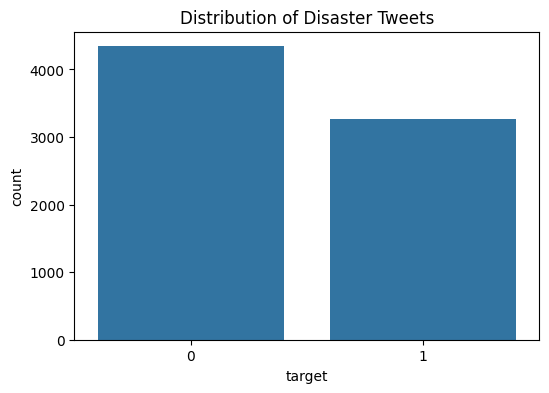

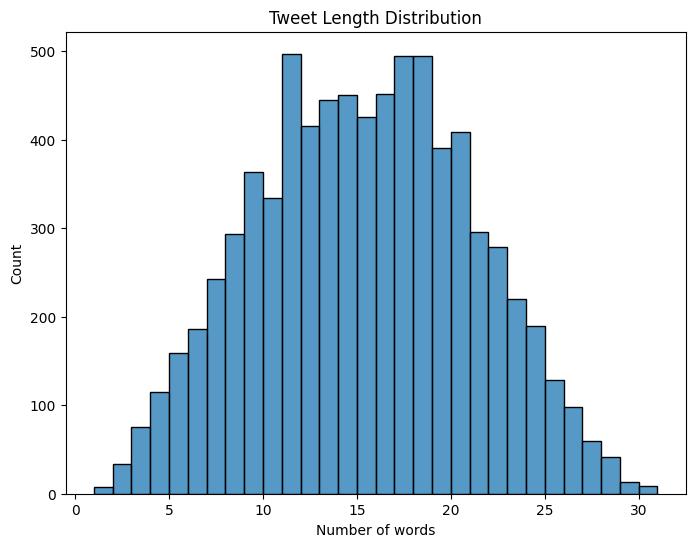

In [ ]:
analysis.initial_eda()

# 2 - Exploratory Data Analysis

### Data Inspection and Visualization
- **Data Loading:**  
  The dataset is loaded from CSV files and basic information (shape, head of the data) is printed. The training data is also checked for missing values.
  
- **Visualizations:**  
  - **Target Distribution:** A count plot shows the imbalance between disaster and non-disaster tweets.  
  - **Tweet Length Distribution:** A histogram of tweet word counts provides insight into the variability of text lengths.  
  - **Word Clouds:** Separate word clouds for disaster and non-disaster tweets visually emphasize commonly used words in each category.

### Data Cleaning Procedures
- **Text Cleaning:**  
  Raw tweet text is preprocessed by converting to lowercase, removing URLs, user mentions, hashtags, punctuation, and extra spaces.  
  Stopwords are removed to reduce noise. The cleaning function uses regular expressions and NLTK’s tokenization tools.
  
- **Additional Feature Cleaning:**  
  The `keyword` and `location` features are processed by lowercasing, stripping extra spaces, and removing non-alphanumeric characters. Missing values are replaced with `unknown`.

### Plan of Analysis
- **Preprocessing:**  
  Clean the text data to remove noise and standardize input. Use the cleaned tweets for all subsequent processing.
- **Feature Engineering:**  
  Transform the text data using different methods:  
  - **TF-IDF:** To capture word importance with a simple, yet effective representation.
  - **Word Embeddings:** For deep learning models (LSTM and CNN), convert texts into sequences and pad them to a uniform length.
- **Modeling Approach:**  
  Apply three types of models:
  - A **TF-IDF dense model** (feed-forward neural network) to serve as a baseline.
  - An **LSTM model** to capture sequential dependencies in the text.
  - A **CNN model** to extract local patterns via convolutional filters.
- **Validation Strategy:**  
  Use k-fold cross-validation to ensure robust performance estimates and hyperparameter tuning (via KerasTuner) to optimize each model’s architecture.


# 3 - Model Architecture
### TF-IDF Dense Model
- **Approach:**  
  Use a TfidfVectorizer to convert the cleaned tweets into a numerical feature matrix.  
- **Architecture:**  
  A sequential neural network is built with one or more Dense layers (with ReLU activations) followed by dropout layers for regularization, and a final sigmoid-activated output node for binary classification.
- **Rationale:**  
  TF-IDF captures the importance of words relative to the dataset, and the dense network can learn non-linear decision boundaries from these features. The model achieved an F1 score of ~0.943, demonstrating its effectiveness on this task.

### LSTM Model
- **Approach:**  
  Use a Tokenizer to convert text into sequences and pad them to a uniform length.
- **Architecture:**  
  1. **Embedding Layer:** Maps words into dense vectors of fixed size.  
  2. **LSTM Layer:** Captures long-term dependencies in the sequence data.  
  3. **GlobalAveragePooling1D:** Summarizes the sequence output.  
  4. **Dropout & Dense Layers:** Add regularization and learn complex features.
- **Rationale:**  
  LSTMs are designed to capture sequential context, which is beneficial in understanding the order and dependency of words in tweets. The model reached an F1 score of ~0.936.

### CNN Model
- **Approach:**  
  Similar to the LSTM model, text is tokenized and padded.
- **Architecture:**  
  1. **Embedding Layer:** Converts words to vector representations.  
  2. **1D Convolutional Layer:** Applies filters (with varying kernel sizes) to capture local features and n-gram patterns.  
  3. **GlobalMaxPooling1D:** Reduces the output dimension by taking the maximum activation over time.  
  4. **Dropout & Dense Layers:** Mitigate overfitting and enable non-linear learning.
- **Rationale:**  
  CNNs are effective at detecting local patterns in text (such as key phrases) that are important for classification. This model achieved an F1 score of ~0.913.

### Hyperparameter Tuning
- **Tool:**  
  KerasTuner’s Hyperband method is employed to systematically search for the best hyperparameters.
- **Strategy:**  
  For each model, hyperparameters such as embedding dimensions, number of units in LSTM/CNN layers, dropout rates, and dense layer sizes are tuned using k-fold cross-validation.  
- **Outcome:**  
  Hyperparameter tuning led to optimized architectures; however, the TF-IDF model still outperformed the deep learning models on the hold-out validation set.


Trial 10 Complete [00h 00m 12s]
val_accuracy: 0.7585301995277405

Best val_accuracy So Far: 0.7729659080505371
Total elapsed time: 00h 01m 32s
Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5622 - loss: 0.6874 - val_accuracy: 0.5696 - val_loss: 0.6821
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5779 - loss: 0.6814 - val_accuracy: 0.6916 - val_loss: 0.5981
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8020 - loss: 0.4777 - val_accuracy: 0.7585 - val_loss: 0.4970
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8946 - loss: 0.2952 - val_accuracy: 0.7625 - val_loss: 0.5307
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9221 - loss: 0.2236 - val_accuracy: 0.7323 - val_loss: 0.6994
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9366 - loss: 0.1716 - val_accuracy: 0.7362 - val_loss: 0.6812
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9481 - loss: 0.1436 - 

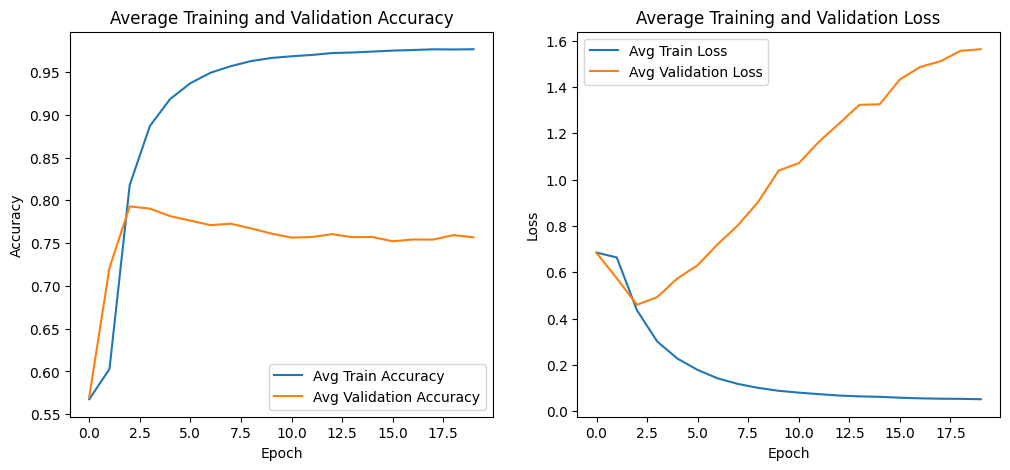

In [ ]:
analysis.tune_lstm_model(epochs=epochs_num, k=k_folds)


Training Fold 1/10 for TF-IDF model...
Reloading Tuner from ./untitled_project/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6005 - loss: 0.6635 - val_accuracy: 0.7822 - val_loss: 0.5030
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8323 - loss: 0.4084 - val_accuracy: 0.7585 - val_loss: 0.5041
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8780 - loss: 0.3044 - val_accuracy: 0.7441 - val_loss: 0.5431
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9006 - loss: 0.2587 - val_accuracy: 0.7559 - val_loss: 0.5908
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9203 - loss: 0.2062 - val_accuracy: 0.7546 - val_loss: 0.6385
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9408 - loss: 0.1707 - val_accuracy: 0.7507 - val_loss: 0.6964
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9468 - loss: 0.1453 - val_accuracy: 0.7297 - val_loss: 0.7633
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9586 - loss: 0.1255 - val_accuracy: 0

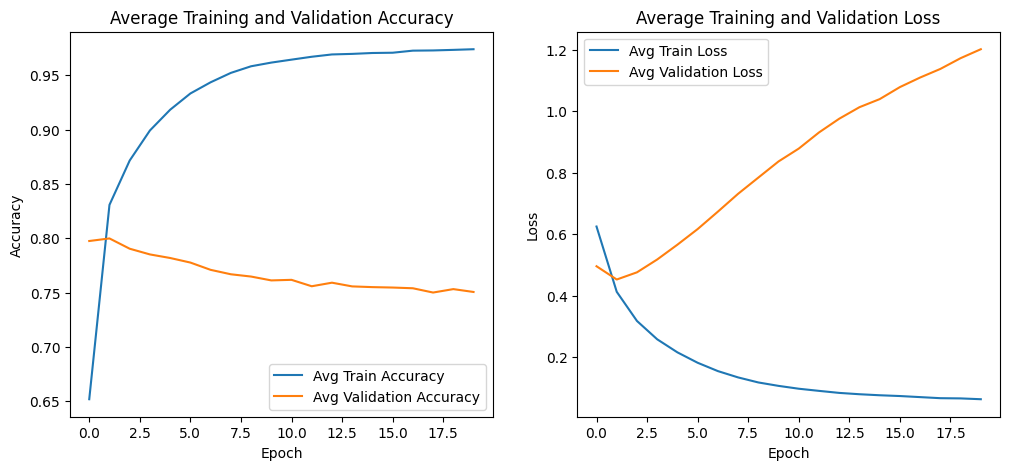

In [ ]:
analysis.tune_tfidf_model(epochs=epochs_num, k=k_folds)


Training Fold 1/10 for CNN model...
Reloading Tuner from ./untitled_project/tuner0.json
Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6051 - loss: 0.6528 - val_accuracy: 0.7848 - val_loss: 0.4801
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8678 - loss: 0.3440 - val_accuracy: 0.7730 - val_loss: 0.5188
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9186 - loss: 0.2254 - val_accuracy: 0.7690 - val_loss: 0.5962
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9513 - loss: 0.1419 - val_accuracy: 0.7533 - val_loss: 0.6925
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9626 - loss: 0.1095 - val_accuracy: 0.7402 - val_loss: 0.7791
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9672 - loss: 0.0932 - val_accuracy: 0.7507 - val_loss: 0.8233
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9732 - loss: 0.0788 - val_accuracy: 0.7375 - val_loss: 0.8957
Epoch 8/20
215

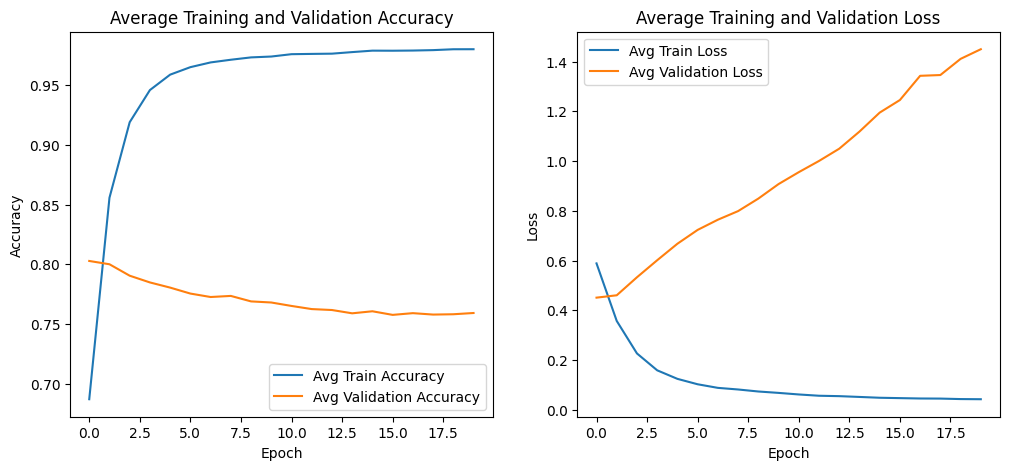

Hold-out split complete.


(4996    courageous honest analysis need use atomic bom...
 3263    wld b shame golf cart became engulfed flames b...
 4907    tell rescind medals honor given us soldiers ma...
 2855    worried ca drought might affect extreme weathe...
 4716               lava blast amp power red pantherattack
                               ...                        
 5226     arent many obliteration servers always like play
 5390    panic attack bc dont enough money drugs alcoho...
 860     omron hemc automatic blood pressure monitor st...
 7603    officials say quarantine place alabama home po...
 7270    moved england five years ago today whirlwind time
 Name: clean_text, Length: 6090, dtype: object,
 2644            new weapon cause unimaginable destruction
 2227    famp things gishwhes got soaked deluge going p...
 5448    dt rt col police catch pickpocket liverpool stree
 132     aftershock back school kick great want thank e...
 6845    response trauma children addicts develop defen...
        

In [ ]:
analysis.tune_cnn_model(epochs=epochs_num, k=k_folds)

In [ ]:
analysis.split_data()

In [ ]:
analysis.compare_model_f1()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Model F1 Score Comparison:
TF-IDF model F1 score: 0.9427244582043344
LSTM model F1 score: 0.9363707776904949
CNN model F1 score: 0.9133738601823708

Best model based on F1 score: TF-IDF


# 4 - Results and Analysis

### Performance Comparison
- **TF-IDF Model:**  
  F1 score: **0.9427**
- **LSTM Model:**  
  F1 score: **0.9364**
- **CNN Model:**  
  F1 score: **0.9134**

The TF-IDF model, despite its relative simplicity, achieved the highest F1 score. This suggests that on this dataset, the carefully preprocessed text combined with the TF-IDF representation captures the essential discriminative features.

### Analysis of Techniques
- **Traditional Feature Engineering:**  
  It was shocking to the success of the TF-IDF model considering it was the most simple.
- **Deep Learning Approaches:**  
  While LSTM and CNN models are powerful in theory, they most likely didn't contend because they tend to work better on larger and more complex data.
- **Hyperparameter Optimization:**  
  The systematic hyperparameter search helped refine the deep learning models. Visualizations of training and validation curves (accuracy and loss) were used to monitor model performance across epochs and folds.
  
### Graphs and Outputs
- **Training Curves:**  
  Aggregated plots across folds show the convergence behavior of the models. These curves are essential to diagnose overfitting or underfitting.
- **Summary Output:**  
  An output summarizing F1 scores provides a clear comparison.


In [ ]:
analysis.prepare_submission()

PREPARING SUBMISSION...
MT:  tfidf
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Submission file saved as: submission.csv


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


# 5 - Conclusion

### Key Learnings and Takeaways
- **Effectiveness of Simpler Methods:**  
  The TF-IDF model outperformed the deep learning models in this experiment. This underscores the importance of a robust feature extraction method when the dataset is relatively small or the text is noisy.
- **Deep Learning Challenges:**  
  Although LSTM and CNN models are theoretically appealing, their performance may be limited by the data size and the need for more complex architectures or pre-trained embeddings.
- **Hyperparameter Tuning:**  
  Using KerasTuner with k-fold cross-validation allowed for a systematic exploration of the model’s design space, which is crucial for achieving good performance.

### Future Improvements
- **Advanced Embeddings:**  
  Experimenting with pre-trained word embeddings (e.g., GloVe, Word2Vec) or even  (e.g., BERT) which I saw other submissions using but I haven't researched.
- **Ensemble Methods:**  
  Combining the predictions of multiple models (e.g., ensembling TF-IDF with deep learning models) could further improve performance.
- **Feature Engineering:**  
  Incorporating additional features from the `keyword` and `location` fields and employing more sophisticated text normalization techniques may enhance the predictive power.